# Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python 

> This tutorial is NOT trying to build a model that predicts the Covid-19 outbreak/pandemic in the best way possible. This is an example of how you can use Recurrent Neural Networks on some real-world Time Series data with PyTorch. Hopefully, there are much better models that predict the number of daily confirmed cases.

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with those types of data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

## Novel Coronavirus (COVID-19)

The novel Coronavirus (Covid-19) has spread around the world very rapidly. At the time of this writing, [Worldometers.info](https://www.worldometers.info/coronavirus/) shows that there are more than *95,488* confirmed cases in more than *84* countries.

The top 4 worst-affected (by far) are China (the source of the virus), South Korea, Italy, and Iran. Unfortunately, many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

### How dangerous is this virus?

Except for the common statistics you might see cited on the news, there are some good and some bad news:

- More than 80% of the confirmed cases recover without any need of medical attention
- [3.4% Mortality Rate estimate by the World Health Organization (WHO) as of March 3](https://www.worldometers.info/coronavirus/coronavirus-death-rate/#who-03-03-20)
- The reproductive number which represents the average number of people to which a single infected person will transmit the virus is between 1.4 and 2.5 [(WHO's estimated on Jan. 23)](https://www.worldometers.info/coronavirus/#repro)

The last one is really scary. It sounds like we can witness some crazy exponential growth if appropriate measures are not put in place.

Let's get started!

In [1]:
!pip install -Uq watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00


In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 7.9.0

numpy : 1.22.4
pandas: 1.4.4
torch : 1.13.1+cu116



In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country. [The dataset is available on GitHub](https://github.com/CSSEGISandData/COVID-19) and is updated regularly.

We're going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available):

In [4]:
# !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

Or you can take the same dataset that I've used for this tutorial (the data snapshot is from 3 March 2020):

In [5]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 27.7MB/s]


## Data exploration

Let's load the data and have a peek:

In [6]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [7]:
df = df.iloc[:, 4:]

In [8]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,...,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,...,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,...,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,...,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,91,91,91,91,91


Let's check for missing values:

In [9]:
df.isnull().sum().sum()

0

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [10]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

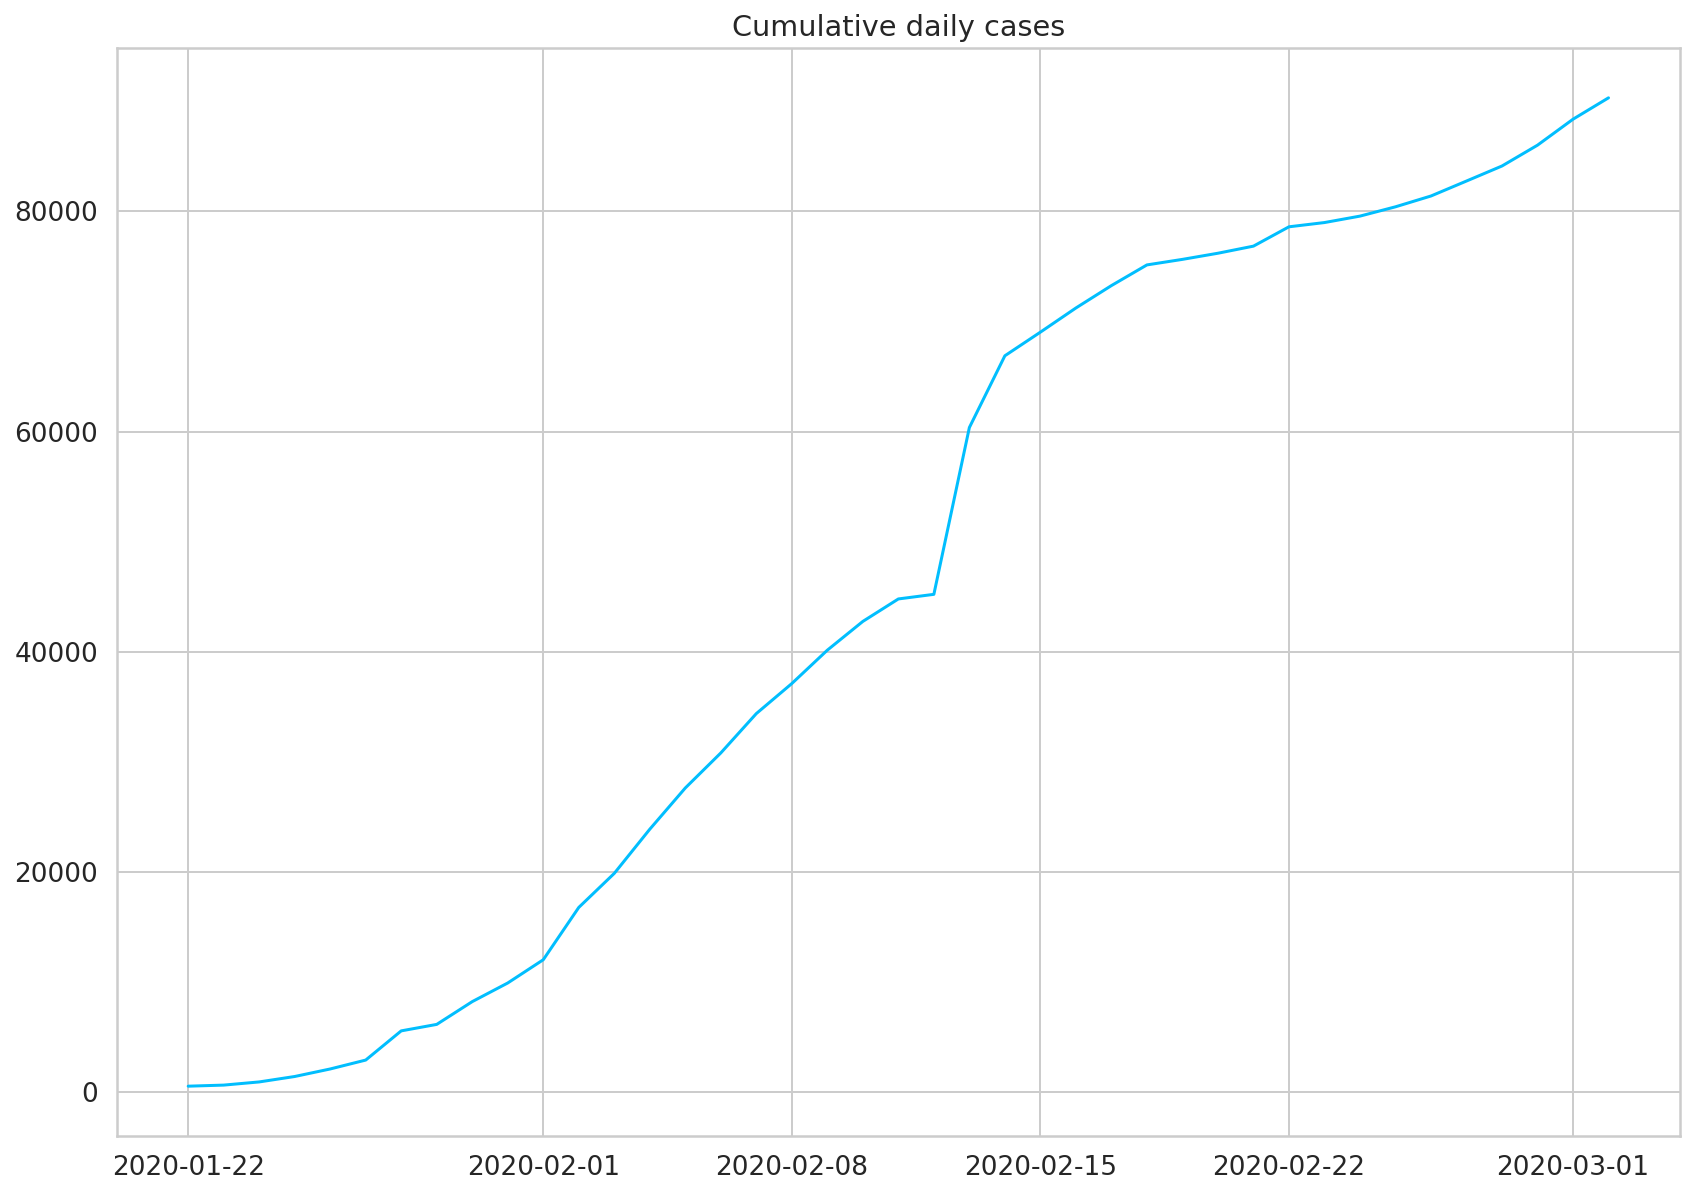

In [11]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [12]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

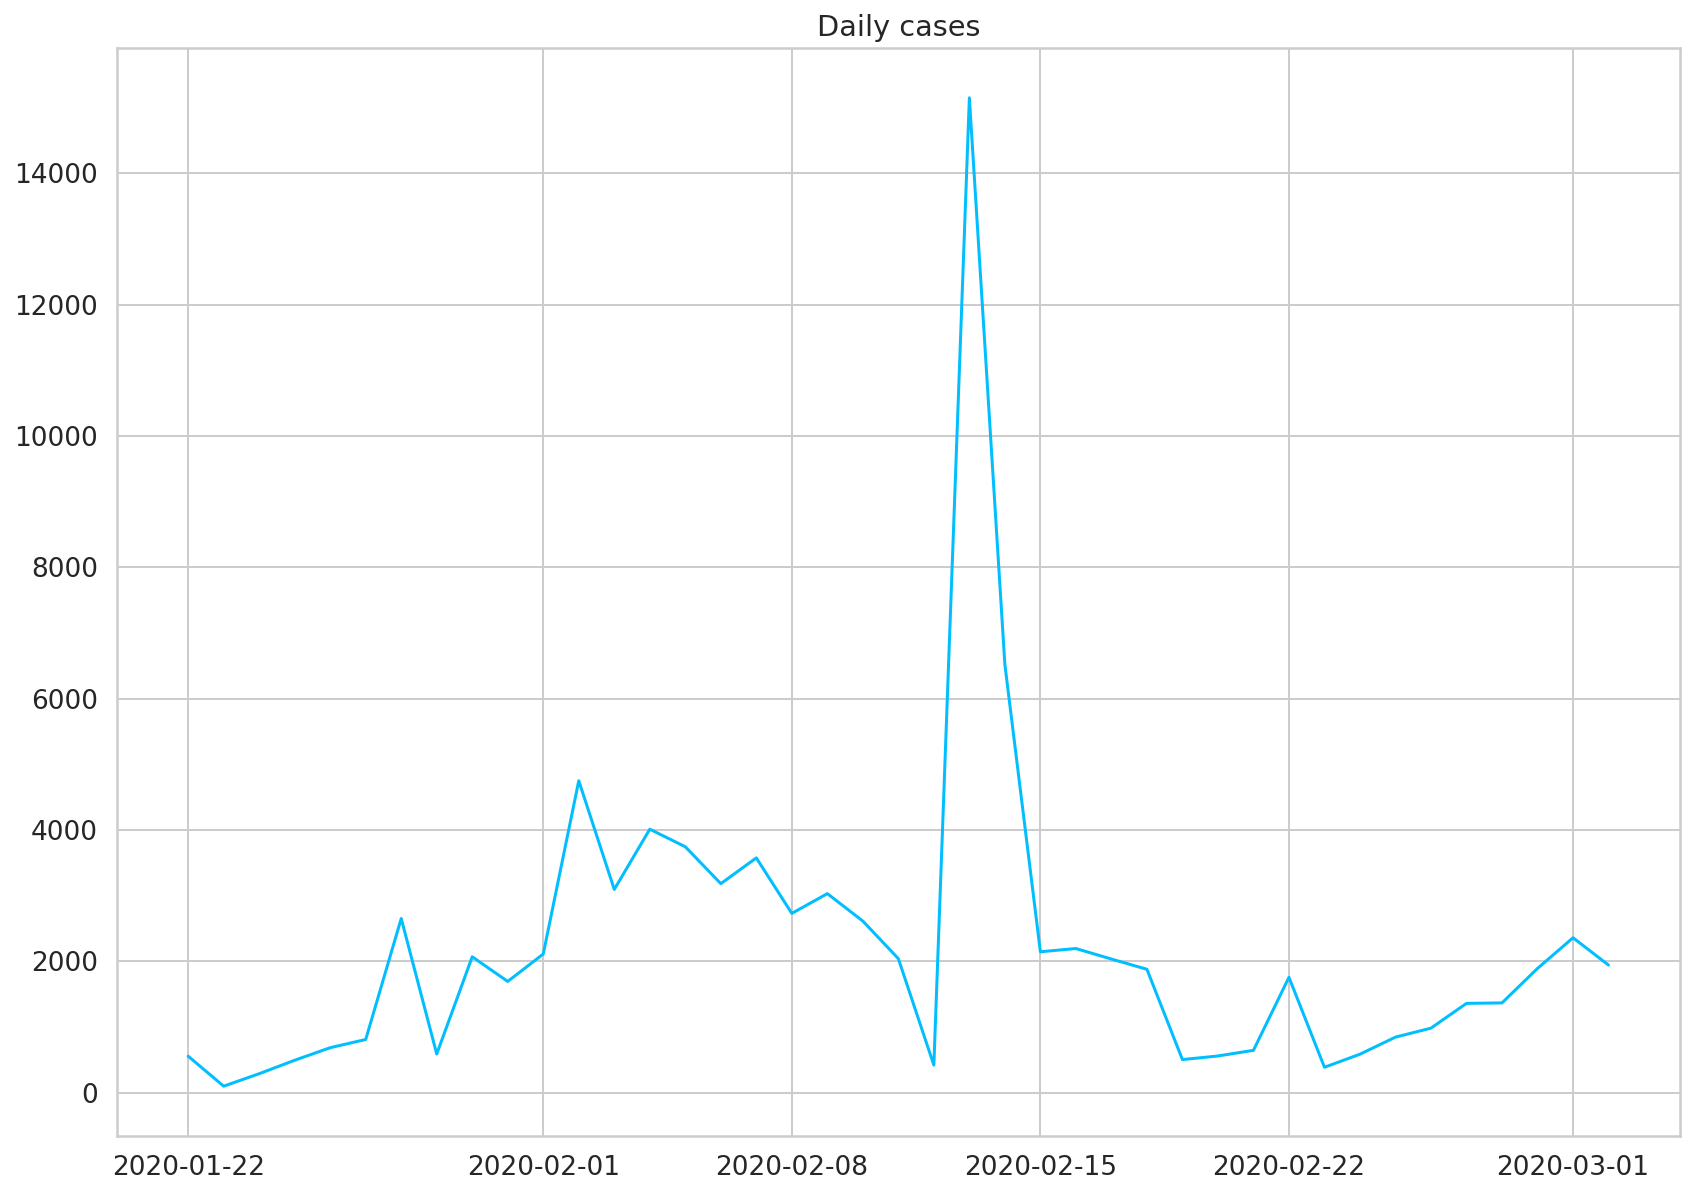

In [13]:
plt.plot(daily_cases)
plt.title("Daily cases");

The huge spike (in the middle) is mostly due to a change of criteria for testing patients in China. This will certainly be a challenge for our model.

Let's check the amount of data we have:

In [14]:
daily_cases.shape

(41,)

Unfortunately, we have data for only 41 days. Let's see what we can do with it!

## Preprocessing

We'll reserve the first 27 days for training and use the rest for testing:

In [15]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(27,)

We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [16]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [17]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [18]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [19]:
X_train.shape

torch.Size([21, 5, 1])

In [20]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [21]:
y_train.shape

torch.Size([21, 1])

In [22]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [23]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [24]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [25]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [26]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.6297187805175781 test loss: 0.041186608374118805
Epoch 10 train loss: 0.8466923832893372 test loss: 0.12416432797908783
Epoch 20 train loss: 0.8219934701919556 test loss: 0.1438201516866684
Epoch 30 train loss: 0.8200691938400269 test loss: 0.2190694659948349
Epoch 40 train loss: 0.8108391165733337 test loss: 0.1797715425491333
Epoch 50 train loss: 0.7957305908203125 test loss: 0.19855867326259613


Let's have a look at the train and test loss:

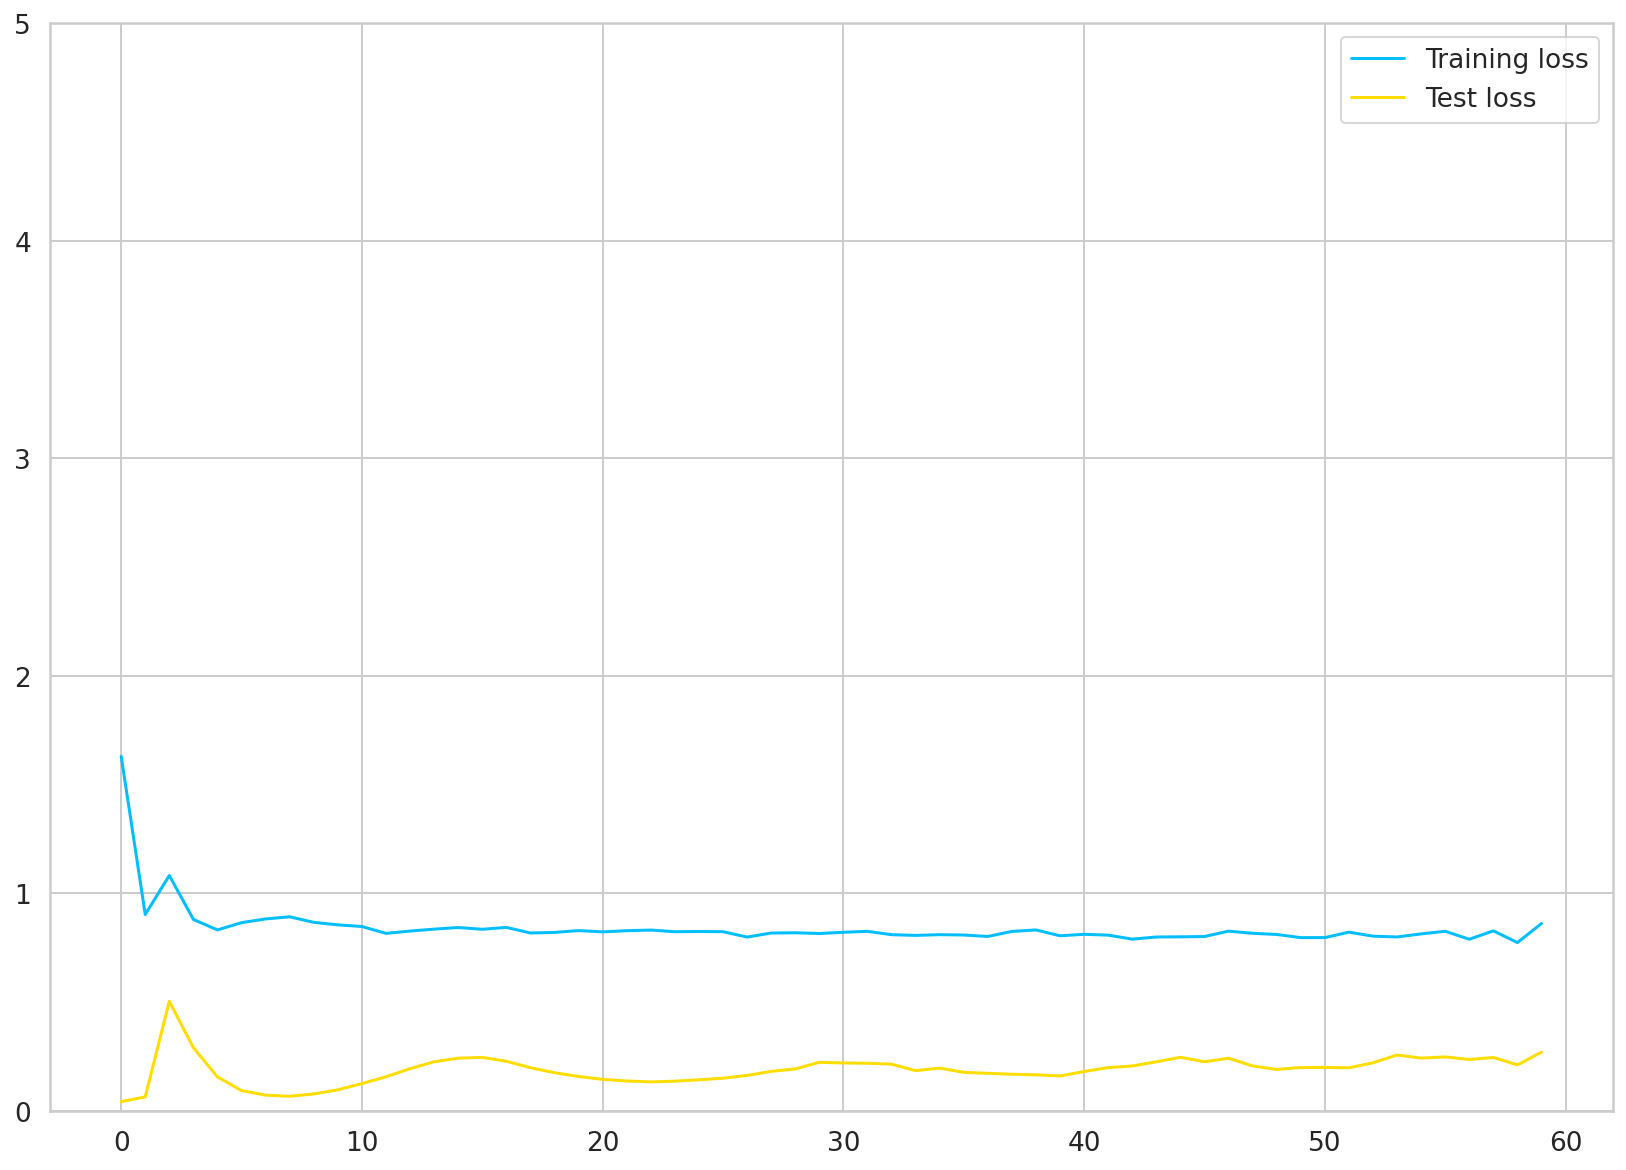

In [27]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [28]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [29]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Let's look at the results:

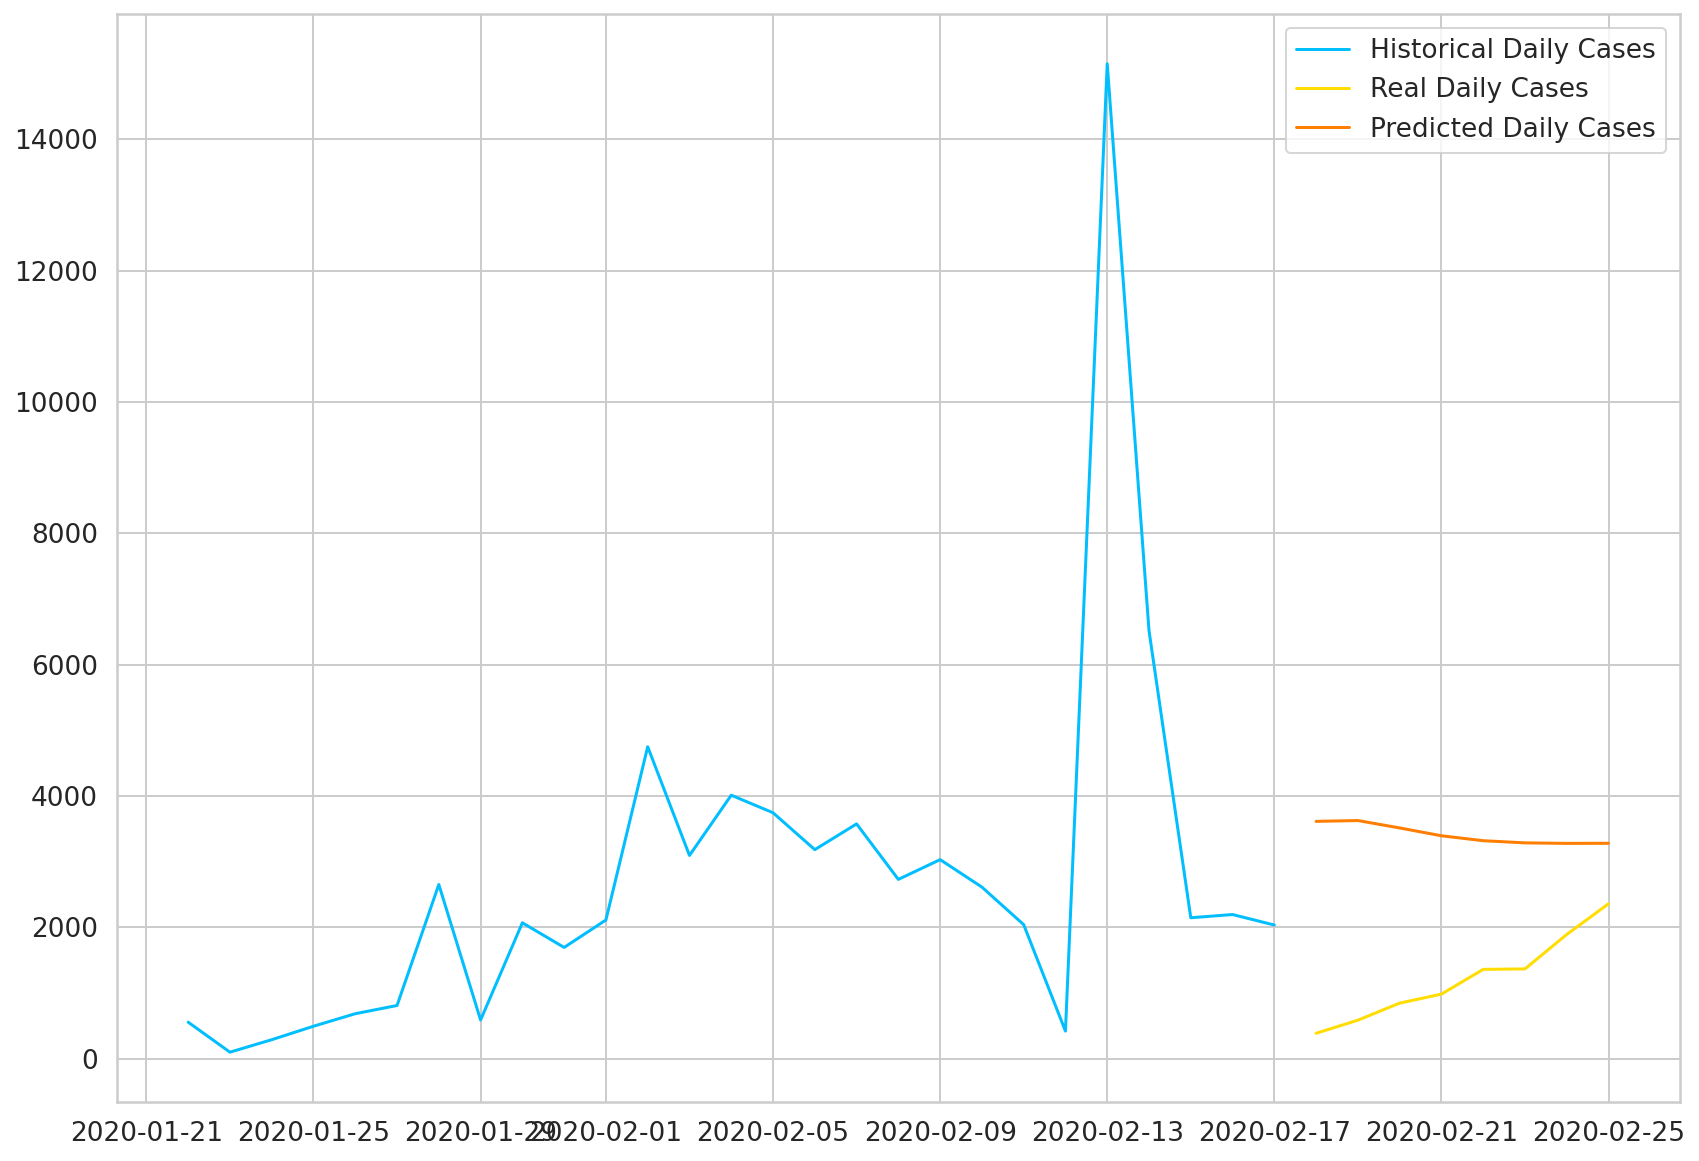

In [30]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

As expected, our model doesn't perform very well. That said, the predictions seem to be in the right ballpark (probably due to using the last data point as a strong predictor for the next).

## Use all data for training

Now, we'll use all available data to train the same model:

In [31]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

The preprocessing and training steps are the same:

In [32]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.9441421031951904
Epoch 10 train loss: 0.8385427594184875
Epoch 20 train loss: 0.8256546258926392
Epoch 30 train loss: 0.8023680448532104
Epoch 40 train loss: 0.8125612139701843
Epoch 50 train loss: 0.8225002884864807


## Predicting future cases

We'll use our "fully trained" model to predict the confirmed cases for 12 days into the future:

In [33]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [34]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [35]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

<ipython-input-36-87968baf4054>:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


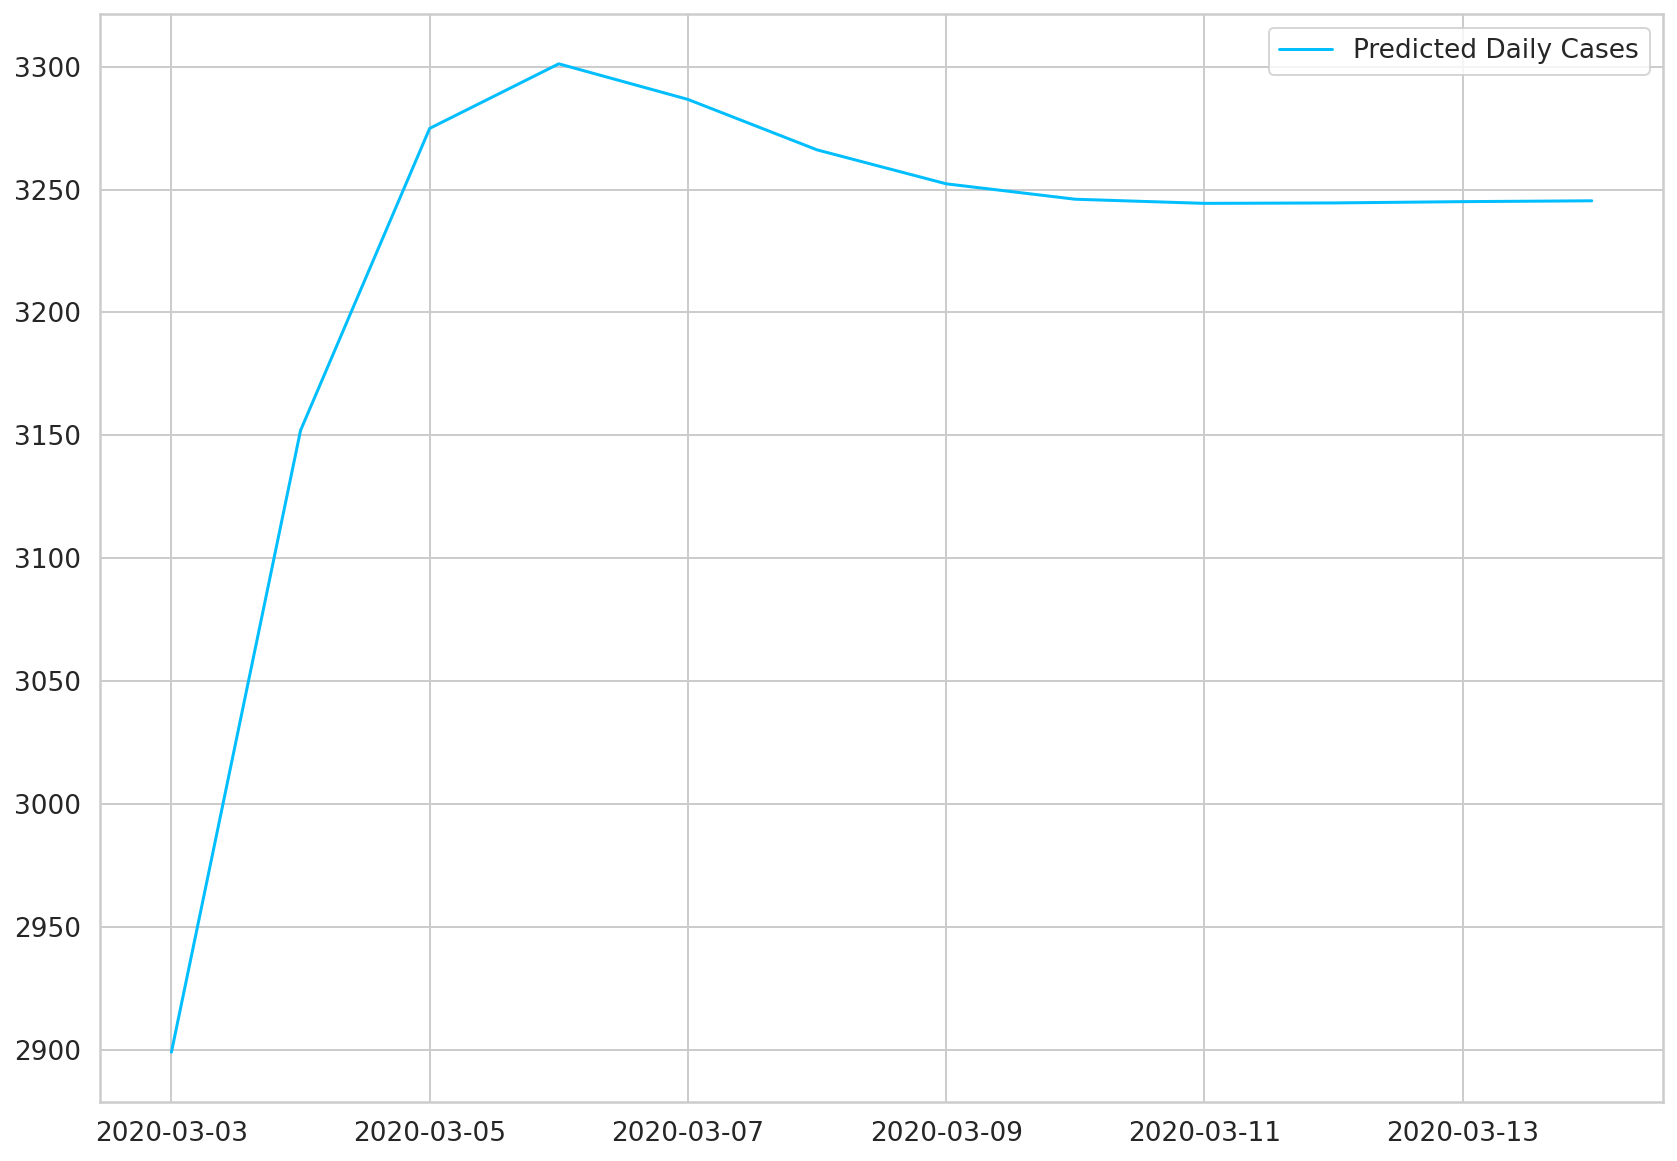

In [36]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Now we can use all the data to plot the results:

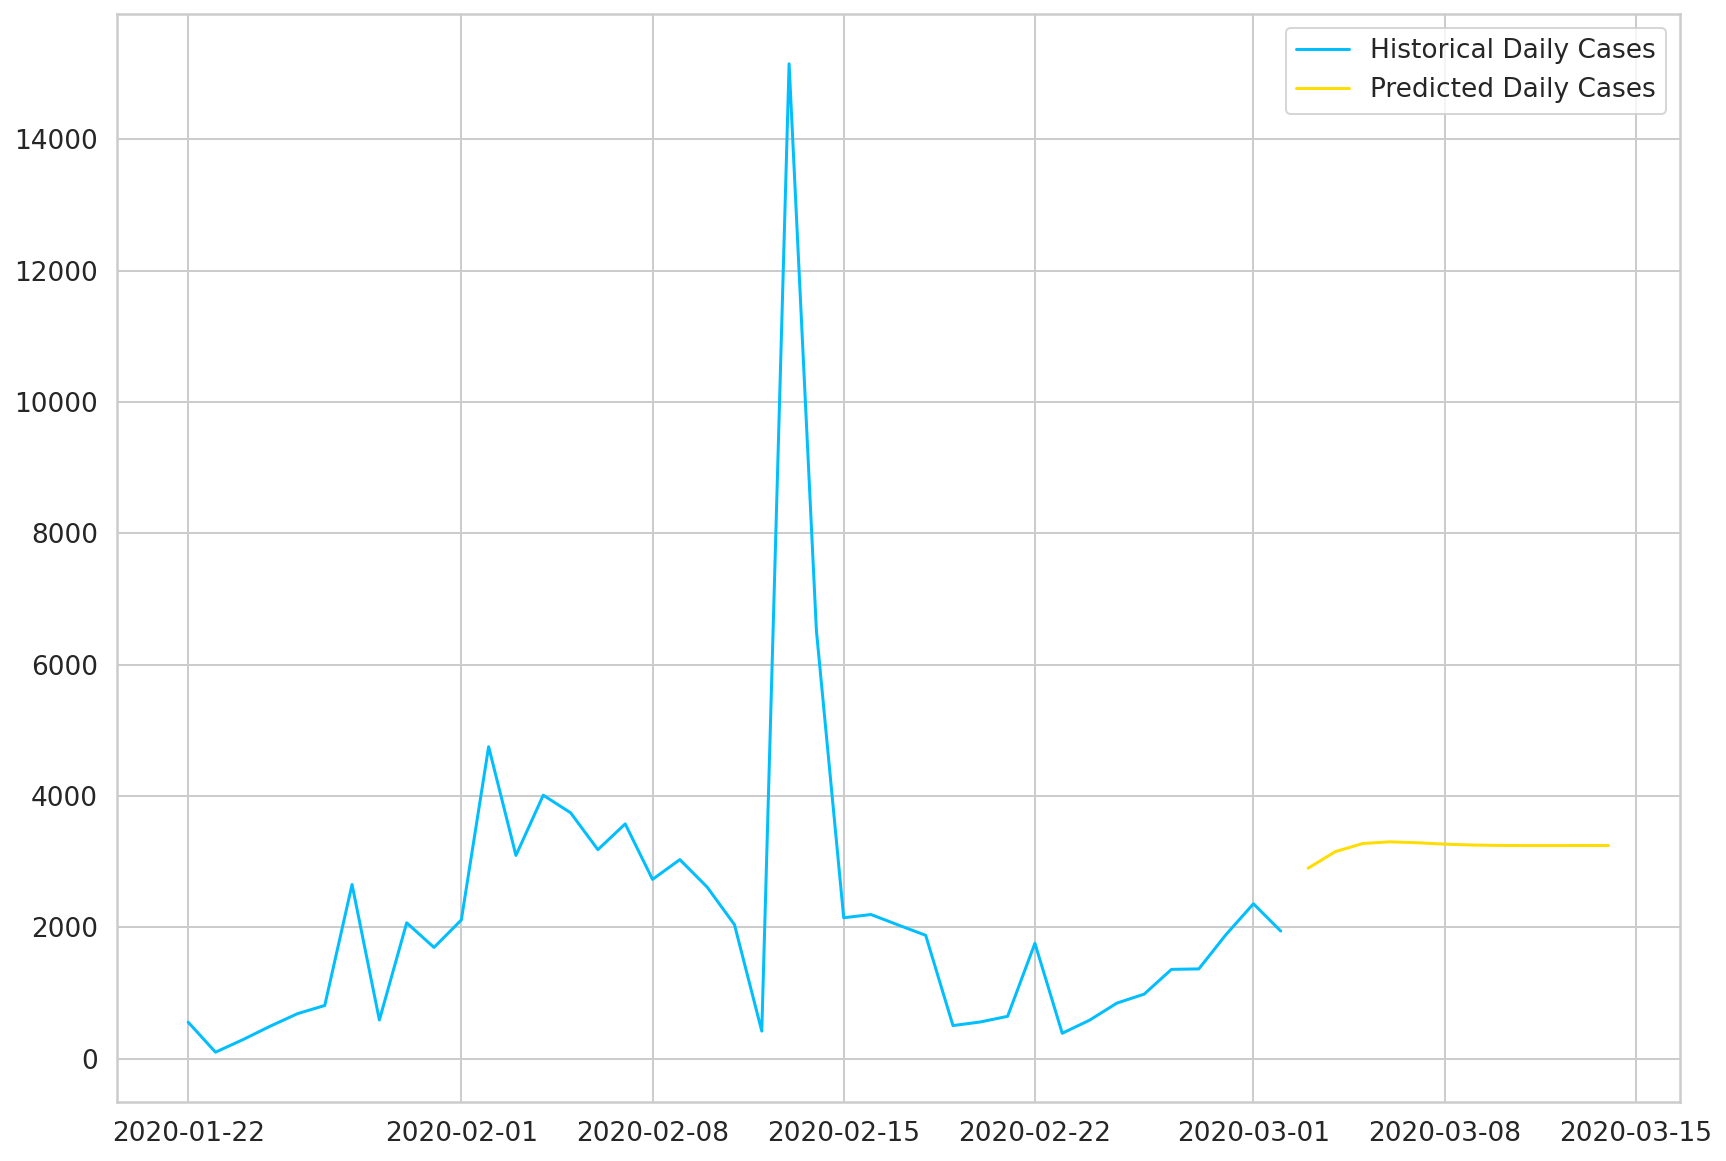

In [37]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Our model thinks that things will level off. Note that the more you go into the future, the more you shouldn't trust your model predictions.

## Conclusion

Well done! You learned how to use PyTorch to create a Recurrent Neural Network that works with Time Series data. The model performance is not that great, but this is expected, given the small amounts of data.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

The problem of predicting daily Covid-19 cases is a hard one. We're amidst an outbreak, and there's more to be done. Hopefully, everything will be back to normal after some time.

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [How does Coronavirus compare to Ebola, SARS, etc?](https://www.youtube.com/watch?v=6dDD2tHWWnU)
- [Worldometer COVID-19 Coronavirus Outbreak](https://www.worldometers.info/coronavirus/)
- [How contagious is the Wuhan Coronavirus? (Ro)](https://www.worldometers.info/coronavirus/#repro)
- [Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note](https://www.academia.edu/41743064/Systemic_Risk_of_Pandemic_via_Novel_Pathogens_-_Coronavirus_A_Note)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
